<h1> Using MCMC to fit COVID-19 epidemiological parameters

In [ ]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')

This Notebook is inspired by Deephaven labs:
https://github.com/deephaven/covid-19-sir-modelling

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Reading and exploring COVID Data
The first step in building a model is collecting data. Here, we will pull data from the COVID Tracking Project (https://covidtracking.com) that used to update daily until March 2021. We will then trim and store our data accordingly.

In [2]:
# making dict of state populations
state_population = {'AK': 731545, 'AL': 4903185, 'AR': 3017804, 'AS': 49437, 'AZ': 7278717,
             'CA': 39512223, 'CO': 5758736, 'CT': 3565287, 'DC': 705749, 'DE': 973764,
             'FL': 21477737, 'GA': 10617423, 'GU': 168485, 'HI': 1415872, 'IA': 3155070,
             'ID': 1787065, 'IL': 12671821, 'IN': 6732219, 'KS': 2913314, 'KY': 4467673,
             'LA': 4648794, 'MA': 6892503, 'MD': 6045680, 'ME': 1344212, 'MI': 9986857,
             'MN': 5639632, 'MO': 6137428, 'MP': 51433, 'MS': 2976149, 'MT': 1068778,
             'NC': 10488084, 'ND': 762062, 'NE': 1934408, 'NH': 1359711, 'NJ': 8882190,
             'NM': 2096829, 'NV': 3080156, 'NY': 19453561, 'OH': 11689100, 'OK': 3956971,
             'OR': 4217737, 'PA': 12801989, 'PR': 3193694, 'RI': 1059361, 'SC': 5148714,
             'SD': 884659, 'TN': 6829174, 'TX': 28995881, 'UT': 3205958, 'VA': 8535519,
             'VI': 106235, 'VT': 623989, 'WA': 7614893, 'WI': 5822434, 'WV': 1792147,
             'WY': 578759}
    
# this function will attempt to fill in missing data from each state as accurately as possible
def fill_na(df):
    df = df.sort_values(by=['date'])
    filled_df = []
    
    # loop through table for each state
    for state in np.unique(df.state):
        # # subset by state
        this_df = df.loc[df.state == state,]
        # # fill NA forward with first good value
        this_df = this_df.fillna(method='ffill')
        # # fill NA backward with zero, this ASSUMES deaths were 0 before first set of reported deaths
        this_df.hospitalized = this_df.hospitalized.fillna(0)
        this_df.death = this_df.death.fillna(0)
        # # appending filled data to filledDf
        filled_df.append(this_df)

    # concatenating filledDf into dataframe
    filled_df = pd.concat(filled_df)

    return filled_df

# this function will take in a csv and a name and return a dataframe with that name
def load_us_df(file, data_filter=None):
    df = pd.read_csv(file)
    df = df[['date','state','positive','negative','recovered','death','hospitalized','total']]
    df['date'] = df['date'].apply(lambda d: str(d)[0:4] + '-' + str(d)[4:6] + '-' + str(d)[6:8])
    if data_filter:
        df = df[(df.date >= data_filter[0]) & (df.date <= data_filter[1])]
    df = fill_na(df)
    
    return df

# URL of data
historicalStatesURL = 'https://api.covidtracking.com/v1/states/daily.csv'
data_filter = ['2020-01-12', '2020-07-11']
# Until 11Aug2020: DC, PR no hosp; GU, VI few dead no hosp; MP few all; AS no data;
# Originally deemed poor data: "AS","DC","GU","MP","PR","VI"
state_filter = ['AS', 'DC', 'GU', 'MP', 'PR', 'VI']
# loading data
state_data = load_us_df(historicalStatesURL, data_filter)
state_data = state_data[~state_data.state.isin(state_filter)]

state_data

,date,state,positive,negative,recovered,death,hospitalized,total
20451,2020-03-06,AK,NaN,NaN,NaN,0.0,0.0,1
20400,2020-03-07,AK,NaN,NaN,NaN,0.0,0.0,2
20349,2020-03-08,AK,NaN,NaN,NaN,0.0,0.0,6
20298,2020-03-09,AK,NaN,NaN,NaN,0.0,1.0,9
20247,2020-03-10,AK,NaN,NaN,NaN,0.0,1.0,9
...,...,...,...,...,...,...,...,...
13663,2020-07-07,WY,1711.0,36078.0,1274.0,20.0,119.0,37789
13607,2020-07-08,WY,1740.0,36078.0,1291.0,21.0,120.0,37818
13551,2020-07-09,WY,1774.0,37271.0,1313.0,21.0,121.0,39045
13495,2020-07-10,WY,1790.0,38077.0,1327.0,21.0,121.0,39867


In [13]:
print(sorted(list(zip(state_population.items(), [state_data[state_data.state == s].iloc[-1].death if s in state_data.state.values else -1 for s in state_population])), key=lambda x: x[0][1]))

[(('AS', 49437), -1), (('MP', 51433), -1), (('VI', 106235), -1), (('GU', 168485), -1), (('WY', 578759), 21.0), (('VT', 623989), 56.0), (('DC', 705749), -1), (('AK', 731545), 17.0), (('ND', 762062), 91.0), (('SD', 884659), 109.0), (('DE', 973764), 517.0), (('RI', 1059361), 976.0), (('MT', 1068778), 29.0), (('ME', 1344212), 112.0), (('NH', 1359711), 391.0), (('HI', 1415872), 19.0), (('ID', 1787065), 101.0), (('WV', 1792147), 95.0), (('NE', 1934408), 286.0), (('NM', 2096829), 543.0), (('KS', 2913314), 284.0), (('MS', 2976149), 1230.0), (('AR', 3017804), 313.0), (('NV', 3080156), 592.0), (('IA', 3155070), 748.0), (('PR', 3193694), -1), (('UT', 3205958), 212.0), (('CT', 3565287), 4348.0), (('OK', 3956971), 421.0), (('OR', 4217737), 232.0), (('KY', 4467673), 622.0), (('LA', 4648794), 3403.0), (('AL', 4903185), 1114.0), (('SC', 5148714), 951.0), (('MN', 5639632), 1537.0), (('CO', 5758736), 1725.0), (('WI', 5822434), 828.0), (('MD', 6045680), 3310.0), (('MO', 6137428), 1069.0), (('IN', 6732219

In [14]:
state_data[state_data.state == 'WY']

,date,state,positive,negative,recovered,death,hospitalized,total
20587,2020-03-01,WY,NaN,NaN,NaN,0.0,0.0,0
20576,2020-03-02,WY,NaN,NaN,NaN,0.0,0.0,0
20564,2020-03-03,WY,NaN,NaN,NaN,0.0,0.0,0
20548,2020-03-04,WY,NaN,NaN,NaN,0.0,0.0,0
20522,2020-03-05,WY,NaN,NaN,NaN,0.0,0.0,0
...,...,...,...,...,...,...,...,...
13663,2020-07-07,WY,1711.0,36078.0,1274.0,20.0,119.0,37789
13607,2020-07-08,WY,1740.0,36078.0,1291.0,21.0,120.0,37818
13551,2020-07-09,WY,1774.0,37271.0,1313.0,21.0,121.0,39045
13495,2020-07-10,WY,1790.0,38077.0,1327.0,21.0,121.0,39867


# Bayesian Modelling

<h2> (Side) Simple example of pymc3

In [2]:
i = 0
@tt.compile.ops.as_op(itypes=[tt.dvector, tt.dmatrix],otypes=[tt.dscalar])
def get_error(x1, x2):
    err = ((x1 - x2) ** 2).mean()
    global i
    if abs(i - err) > 0.05:
        print(f'Latest error: {err}')
    i = err
    return err

In [3]:
N = 100
seed = 11
X = np.random.default_rng(seed).standard_normal(N)
eps = np.random.default_rng(seed).standard_normal((N, 1))*.3
y = X*.4 + 1.5 + eps

with pm.Model() as m0:
    beta = pm.Normal('beta', 0, 10)
    a = pm.Normal('a', 0, 10)
    sd = pm.HalfNormal('sd', 5)
    loss = pm.Deterministic('loss', get_error(X*beta+a, theano.shared(y)))
    pm.Normal('y', X*beta+a, sd, observed=y)
    trace0 = pm.sample(return_inferencedata=True, chains=2, cores=1)

Latest error: 2.5120077034896138


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, a, beta]


Latest error: 4.014317324866072
Latest error: 3.7976292231754427
Latest error: 3.67051478323279
Latest error: 2.990336591665009
Latest error: 2.90899649004778
Latest error: 2.7866895288358533
Latest error: 2.568856244387978
Latest error: 0.1092271615173876


Latest error: 2.5120077034896138
Latest error: 1.309152445592219
Latest error: 0.8032195406234186
Latest error: 0.14159719420716138


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


Latest error: 2.5120077034896138


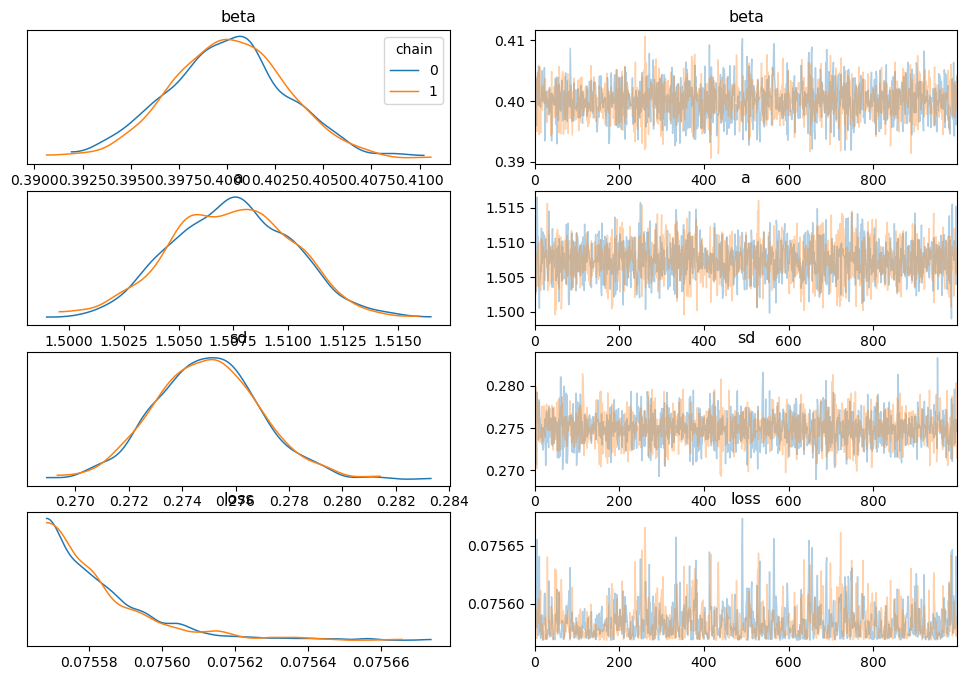

In [4]:
pl = pm.plot_trace(trace0, legend=True, chain_prop={"color": ['C0', 'C1', 'C2', 'C3', "xkcd:purple blue"]})

In [5]:
pm.find_MAP(model=m0)


Latest error: 0.07556834321049391


{'beta': array(0.4),
 'a': array(1.50739949),
 'sd_log__': array(-1.291359),
 'sd': array(0.27489694),
 'loss': 0.07556834321049391}

In [6]:
pm.summary(trace0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.400,0.003,0.394,0.406,0.0,0.0,2267.0,1487.0,1.0
a,1.507,0.003,1.502,1.512,0.0,0.0,2507.0,1469.0,1.0
sd,0.275,0.002,0.271,0.279,0.0,0.0,2436.0,1397.0,1.0
loss,0.076,0.000,0.076,0.076,0.0,0.0,926.0,1337.0,1.0


In [7]:
t = pm.sample_posterior_predictive(trace0, samples=200, var_names=['beta', 'a', 'sd', 'y'], model=m0)
print(t['beta'])

e:\Anaconda\envs\graph\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


[0.39986875 0.40101748 0.39977453 0.402563   0.39598455 0.40354536
 0.40179756 0.40471062 0.40241413 0.39927458 0.40564837 0.40561909
 0.39947471 0.39947471 0.39897536 0.40026013 0.40020882 0.40322477
 0.40498663 0.39992557 0.40165695 0.40039703 0.40042369 0.4054905
 0.39345121 0.39394282 0.4013258  0.4009146  0.40162691 0.39899943
 0.40027214 0.39972856 0.39974419 0.39773917 0.40071559 0.40226001
 0.39820483 0.39862814 0.39827535 0.40126425 0.39345741 0.40123485
 0.40100022 0.40098186 0.40010265 0.39953675 0.39938925 0.40055202
 0.39934087 0.40373812 0.39615357 0.39615357 0.40394347 0.39295813
 0.39934434 0.40384884 0.39683319 0.40282058 0.39978207 0.40153494
 0.39861878 0.39837222 0.39837222 0.39961155 0.4034046  0.39945121
 0.39675404 0.39884958 0.400735   0.40125889 0.40168974 0.39806836
 0.39697841 0.40461223 0.40292648 0.39789244 0.40333035 0.3966333
 0.39864812 0.39993593 0.4008232  0.40158392 0.39931522 0.39905239
 0.40865036 0.40518336 0.40220504 0.39808703 0.39665911 0.397800

<Axes: xlabel='y / y'>

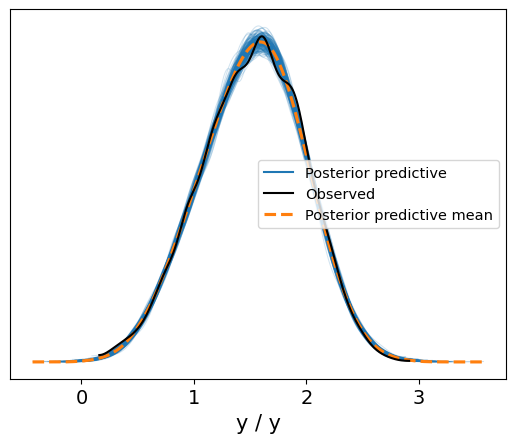

In [8]:
import arviz as az
pm.plot_ppc(az.from_pymc3(posterior_predictive=t, model=m0))

array([<Axes: title={'center': 'beta'}>, <Axes: title={'center': 'a'}>],
      dtype=object)

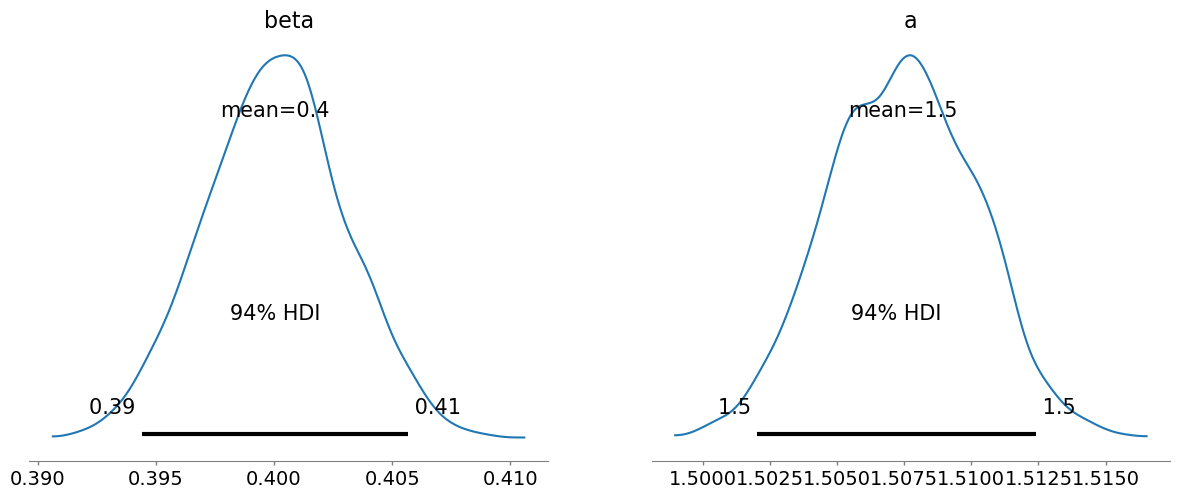

In [9]:
pm.plot_posterior(trace0, var_names=['beta', 'a'])

In [10]:
import scipy.stats as st
print(st.norm.fit(trace0.posterior['beta']))
print(st.norm.fit(trace0.posterior['a']))

(0.400048757108897, 0.003019176606439983)
(1.5074427059349877, 0.0027900403470376626)


<h2> Epidemic modelling

Here we define a function that will take in data as well as initial conditions and perform a Markov-Chain Monte Carlo simulation on the given data generation model to estimate the parameters of the SIR model in question.

Running WY with Population 10000 AND 0 hosp NaNs AND 0 death NaNs
pos=1839.0, rec=1361.0, hos=123.0, dea=21.0, tot=39916.0, beta=0.02540, gamma=0.06851, rho_h=0.02330, rho=0.00694


e:\Anaconda\envs\graph\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Death error: 137.4249089546101


Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Sampled i0=9; beta=0.02397116959290879; gamma=0.07196938957659042; rho_h=0.02329967; rho=0.007241113116148113
Sampled i0=10; beta=0.02328187386957875; gamma=0.07299985224101704; rho_h=0.02329967; rho=0.0074620969458979
Death error: 137.23447108527495
Sampled i0=11; beta=0.025708264230457942; gamma=0.0799674433430214; rho_h=0.02329967; rho=0.0073885038048765415
Death error: 137.05337214246762
Sampled i0=10; beta=0.02258312044518514; gamma=0.0935929033100042; rho_h=0.02329967; rho=0.007297140160422651
Death error: 137.44509214087273
Sampled i0=8; beta=0.010161857675395599; gamma=0.1298286781704949; rho_h=0.02329967; rho=0.018116717724180574
Death error: 136.3923489519436
Sampled i0=8; be

Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Death error: 137.42490895461006
Sampled i0=7; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Death error: 137.79699425403732
Sampled i0=7; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Sampled i0=6; beta=0.023864006965050748; gamma=0.07610062189790183; rho_h=0.02329967; rho=0.0077204954672195686
Death error: 137.94804958714047
Sampled i0=6; beta=0.023748600897559105; gamma=0.07553285848781938; rho_h=0.02329967; rho=0.00763022541293112
Sampled i0=6; beta=0.023722564428245753; gamma=0.07301641780320466; rho_h=0.02329967; rho=0.007838421077411319
Sampled i0=5; beta=0.023479363865478255; gamma=0.07299239225422104; rho_h=0.02329967; rho=0.007910940629141078
Death error: 138.10739230742843
Sampled i0=5; beta=0.0234372403826579; gamma=0.07284066396106878; rho_h=0.02329967; rho=0.007898756538155586
Sampled i0=6;

Sampling 2 chains for 200 tune and 100 draw iterations (400 + 200 draws total) took 112 seconds.


Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
e:\Anaconda\envs\graph\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


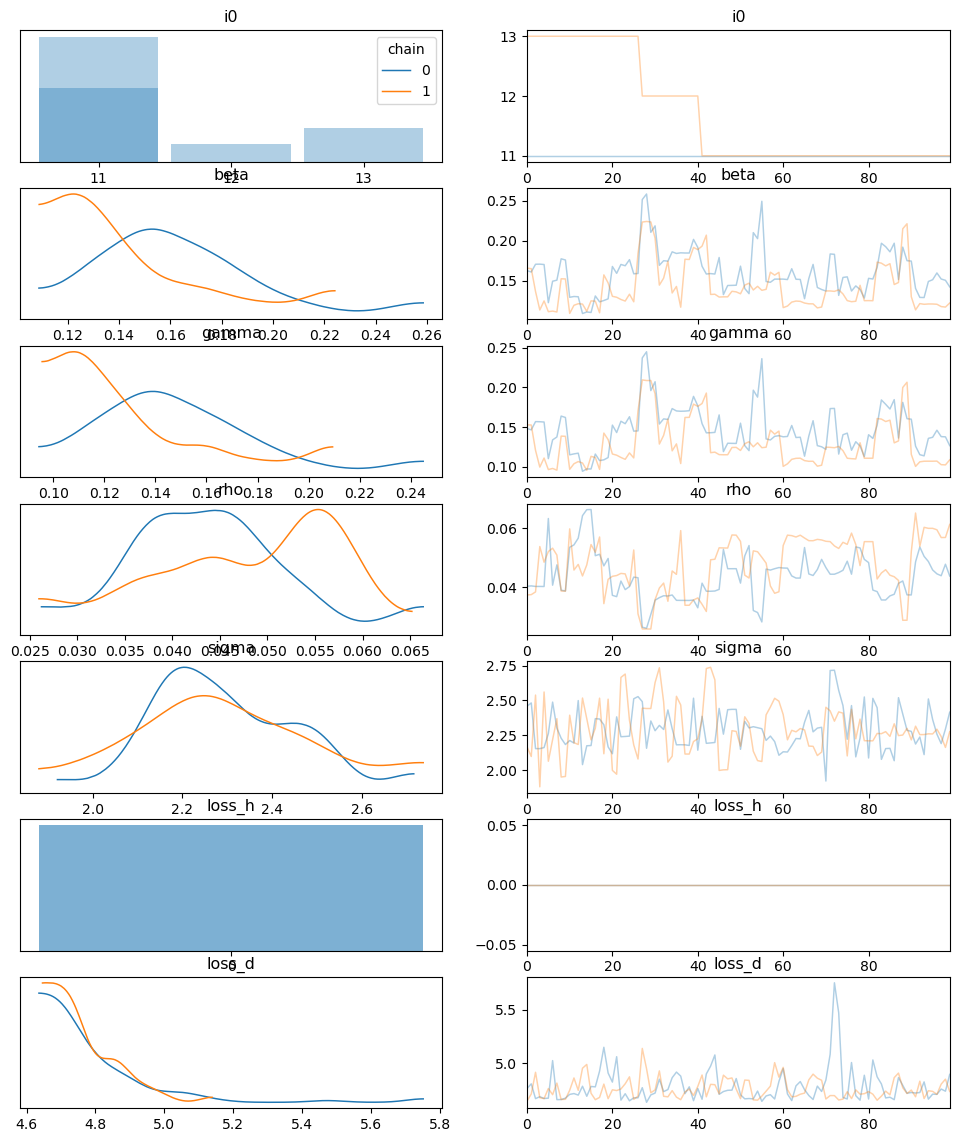

summary:
    param      mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean    r_hat state
0      i0  11.34000  0.70490  11.00000   13.00000    0.41317  2.20702    WY
1    beta   0.15142  0.03011   0.10872    0.21060    0.00558  1.08487    WY
2   gamma   0.13753  0.03030   0.09427    0.19655    0.00557  1.08523    WY
3     rho   0.04577  0.00887   0.02591    0.05986    0.00190  1.10668    WY
4   sigma   2.28993  0.16849   1.87894    2.57195    0.01370  1.12664    WY
5  loss_h   0.00000  0.00000   0.00000    0.00000    0.00000      NaN    WY
6  loss_d   4.77330  0.13544   4.63485    5.00706    0.01296  1.00044    WY
WY succeeded


In [6]:
from ct_simulator.mcmc import run_loop
states = ['WY']
trace_results, summary = \
    run_loop(
        state_data=state_data,
        state_population=state_population,
        states=states,
        use_population=10000,
        sample_kwargs=dict(ode=1, model=0, fit_stats=('d',), print_try=0, print_interval=1, print_err_limit=0.1,
                           i0=9, beta=0.02540013, gamma=0.06851045, rho_h=0.02329967, rho=0.00693762,
                           find_map=0, step=None,#{'Metropolis': dict(target_accept=.99)},
                           init='auto', draws=100, tune=200, chains=2, cores=1),
    )

Considering that the full IBMF model is slower to simulate than the ODE analytical solution, we can stop at parameter values that
are close to the true data, without waiting for full parameter convergence. Note, the following can take a long time.

In [4]:
from ct_simulator.mcmc import run_loop
states = ['WY']
trace_results, summary = \
    run_loop(
        state_data=state_data,
        state_population=state_population,
        states=states,
        use_population=10000,
        sample_kwargs=dict(ode=0, model=2, fit_stats=('d',), print_try=0, print_interval=1, print_err_limit=0.1,
                           i0=9, beta=0.02540013, gamma=0.06851045, rho_h=0.02329967, rho=0.00693762,
                           find_map=0, step=None,#{'Metropolis': dict(target_accept=.99)},
                           init='auto', draws=10, tune=20, chains=2, cores=1),
    )

Running WY with Population 10000 AND 0 hosp NaNs AND 0 death NaNs
pos=1839.0, rec=1361.0, hos=123.0, dea=21.0, tot=39916.0, beta=0.02540, gamma=0.06851, rho_h=0.02330, rho=0.00694


e:\Anaconda\envs\graph\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999
Death error: 139.10526315789474


e:\Anaconda\envs\graph\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Only 10 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [i0]
>CompoundStep
>>Slice: [beta]
>>Slice: [gamma]
>>Slice: [rho]
>NUTS: [sigma]


Sampled i0=9; beta=0.025400129999999996; gamma=0.06851045; rho_h=0.02329967; rho=0.006937619999999999


e:\Anaconda\envs\graph\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\Anaconda\envs\graph\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


WY failed 1st try with Sampling stopped before a sample was created.:
pos=1839.0, rec=1361.0, hos=123.0, dea=21.0, tot=39916.0, beta=0.02540, gamma=0.06851, rho_h=0.02330, rho=0.00694


KeyboardInterrupt: 

<h2> Plotting data fits </h2>

<p> After running the MCMC, we can verify the fits by plotting the predicted outcome against the true data. We first generate the dict of real deaths:

In [8]:
dct = {}
for state in ['WY', 'AK', 'VT', 'ND']:
    data_for_state = state_data.loc[state_data.state == state]
    dataHospital = data_for_state['hospitalized'].to_numpy()
    dataDeath = data_for_state['death'].to_numpy()
    dct[state] = (dataHospital, dataDeath)
dct['WY'][1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  6.,
        6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,
        8., 10., 11., 11., 12., 12., 12., 12., 13., 13., 15., 15., 16.,
       16., 17., 17., 17., 17., 17., 17., 17., 17., 17., 18., 18., 18.,
       18., 18., 18., 18., 18., 18., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 21.,
       21., 21., 21.])

Then we use the parameters we inferred from MCMC to rerun the simulation:

In [9]:
from ct_simulator import run_tracing
pop = 10000
length = len(dct['WY'][1])

# Different settings found after running the MCMC routine...
i0=9; beta=0.02540013; gamma=0.06851045; rho_h=0.02329967; rho=0.00693762; k=3 # WY
# i0=9; beta=0.07984838164998229; gamma=0.3970664071014556; rho_h=0.03354978354978355; rho=0.006407353207631992; k=3 #AK
# i0=30; beta=0.4397572379210608; gamma=0.5733717634623886; rho_h=0.01950078003120125; rho=0.006565624283586454; k=5 #VT
# i0=30; beta=1.693539813; gamma=0.19307147220719303; rho_h=0.03102878716375649; rho=0.00796116571919583; k=10 #ND

lamdahd = rho / rho_h

st, extra = run_tracing.run_api(
                netsize=pop, k=k, first_inf=i0, beta=beta, gamma=gamma, ph=rho_h, lamdahd=lamdahd,
                presample=10000, pa=.2, taur=0, taut=0, 
                nettype='barabasi:5:1', p=.01, use_weights=True, dual=0,
                seed=21, netseed=25, infseed=-1, model='sir', spontan=True, sampling_type='min',
                multip=0, nnets=1, niters=1, nevents=length, sim_agent_based=1,
                animate=-2, summary_print=0, summary_splits=length, avg_without_earlystop=True)

print('Total deaths', st['res']['average-overall-death']['mean'])
res = np.array([i['mean'] for i in st['res']['average-total-death']]) # repeat this for each state, using the parameters obtained from MCMC
print('Aggregated number of daily deaths', res.sum())

Total deaths 18.81
Aggregated number of daily deaths 1290.08


And finally we use the simulation results to generate the data fits: (Note, one needs to rerun the above to generate the res, res2, res3 and res4)

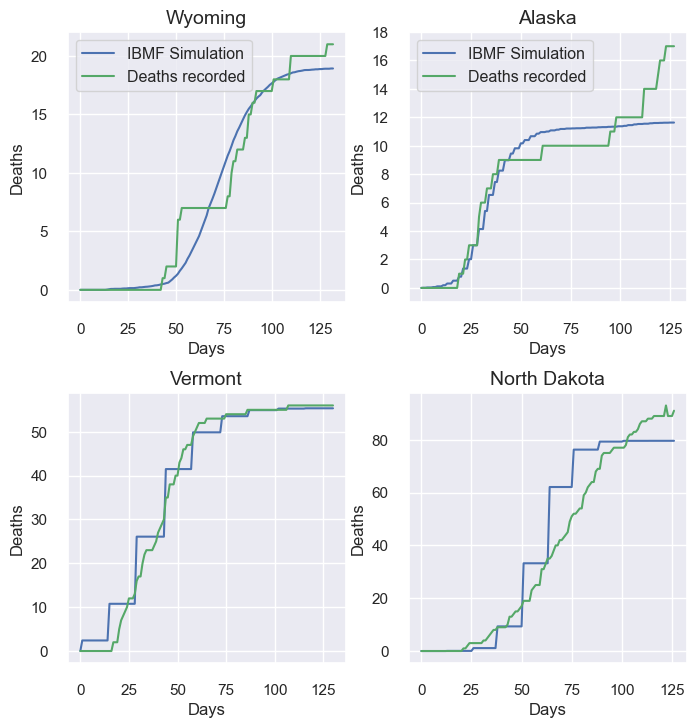

In [96]:
# this needs to be run after obtaining res, res2, res3, res4 for all states
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns; sns.set_theme()
import matplotlib.style as style
style.use('seaborn-deep')
fig, ax = plt.subplots(2, 2, figsize=(7,7))
fig.tight_layout(h_pad=3.5)
label_ibmf = 'IBMF Simulation'
label_death = 'Deaths recorded'
ax[0][0].set_title('Wyoming', fontsize=14)
ax[0][0].plot(res, label=label_ibmf)
ax[0][0].plot(dct['WY'][1], label=label_death)
ax[0][1].set_title('Alaska', fontsize=14)
ax[0][1].plot(res2, label=label_ibmf)
ax[0][1].plot(dct['AK'][1], label=label_death)
ax[0][1].set_ylim(-1, 18)
ax[0][1].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[1][0].set_title('Vermont', fontsize=14)
ax[1][0].plot(res3, label=label_ibmf)
ax[1][0].plot(dct['VT'][1], label=label_death)
ax[1][1].set_title('North Dakota', fontsize=14)
ax[1][1].plot(res4, label=label_ibmf)
ax[1][1].plot(dct['ND'][1], label=label_death)
for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel('Days')
        ax[i][j].set_ylabel('Deaths')
        ax[i][j].tick_params(size=11)

ax[0][0].legend(fontsize=11.5)
ax[0][1].legend(fontsize=11.5)
plt.savefig('fig/fitting.pdf', bbox_inches='tight')

# Plotting overall trends on a map

In [11]:
import plotly.graph_objects as go

In [18]:
summary

,param,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,r_hat,state
0,i0,11.34000,0.70490,11.00000,13.00000,0.41317,2.20702,WY
1,beta,0.15142,0.03011,0.10872,0.21060,0.00558,1.08487,WY
2,gamma,0.13753,0.03030,0.09427,0.19655,0.00557,1.08523,WY
3,rho,0.04577,0.00887,0.02591,0.05986,0.00190,1.10668,WY
4,sigma,2.28993,0.16849,1.87894,2.57195,0.01370,1.12664,WY
5,loss_h,0.00000,0.00000,0.00000,0.00000,0.00000,NaN,WY
6,loss_d,4.77330,0.13544,4.63485,5.00706,0.01296,1.00044,WY


In [12]:
# plotting beta per state
fig_beta = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='beta']['state'], # Spatial coordinates
    z = summary[summary['param']=='beta']['mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'YlOrBr',
    colorbar_title = "Transmission Rate per Day",
))

fig_beta.update_layout(
    title_text = 'MCMC Estimates of COVID-19 Transmission Rate by State',
    geo_scope='usa', # limite map scope to USA
)

fig_beta.show()

In [13]:
# plotting gamma per state
fig_gamma = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='gamma']['state'], # Spatial coordinates
    z = summary[summary['param']=='gamma']['mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Removal Rate per Day",
))

fig_gamma.update_layout(
    title_text = 'MCMC Estimates of COVID-19 Removal Rate by State',
    geo_scope='usa', # limite map scope to USA
)

fig_gamma.show()

In [14]:
# plotting rho per state
fig_rho = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='rho']['state'], # Spatial coordinates
    z = summary[summary['param']=='rho']['mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Mortality Rate per Infection",
))

fig_rho.update_layout(
    title_text = 'MCMC Estimates of COVID-19 Mortality Rate by State',
    geo_scope='usa', # limite map scope to USA
)

fig_rho.show()

In [15]:
# plotting rho per state
fig_rho = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='rho']['state'], # Spatial coordinates
    z = summary[summary['param']=='rho']['mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Mortality Rate per Infection",
))

fig_rho.update_layout(
    title_text = 'MCMC Estimates of COVID-19 Mortality Rate by State',
    geo_scope='usa', # limite map scope to USA
)

fig_rho.show()

In [16]:
# plotting ovrsk per state
fig_ovrsk = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='beta']['state'], # Spatial coordinates
    z = summary[summary['param']=='rho']['mean'].astype(float).to_numpy() * 
        (summary[summary['param']=='beta']['mean'].astype(float).to_numpy() / 
         summary[summary['param']=='gamma']['mean'].astype(float).to_numpy()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Burgyl',
    colorbar_title = "Overall Risk",
))

fig_ovrsk.update_layout(
    title_text = 'Estimated Overall Risk of COVID-19 by State',
    geo_scope='usa', # limite map scope to USA
)

fig_ovrsk.show()